## Cross Validation Ensemble with transformers models

### Overview
This notebook implements a **cross-validation–based ensemble** approach
for the disaster tweet classification task.

Instead of training different model architectures,
the same Transformer model is trained multiple times using
**different training/validation splits** generated by cross-validation.

Predictions from these independently trained models
are then combined to produce a more robust final result.


This notebook was used by google colab.

In [1]:
!pip install transformers datasets evaluate accelerate

In [2]:
from google.colab import drive
import os

drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab Notebooks/NLP_kaggle

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/NLP_kaggle


In [3]:
!unzip -o nlp-getting-started.zip

import pandas as pd
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print(f"number of dataset: {len(train_df)}")

Archive:  nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               
number of dataset: 7613


In [4]:
import torch
import numpy as np
import random
import os

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [5]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
train_df.isna().sum(), train_df.shape

(id             0
 keyword       61
 location    2533
 text           0
 target         0
 dtype: int64,
 (7613, 5))

In [8]:
test_df.isna().sum()

,0
id,0
keyword,26
location,1105
text,0


<Axes: xlabel='target'>

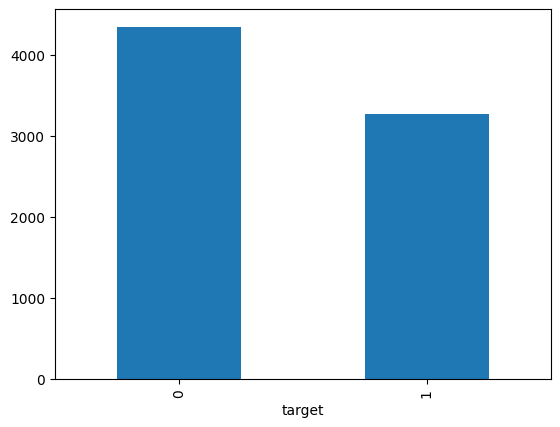

In [9]:
train_df['target'].value_counts().plot(kind="bar")

In [10]:
# cross-validation

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import Dataset

In [11]:
checkpoint = "microsoft/deberta-v3-base"

In [12]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint, use_fast=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
 

In [13]:
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [14]:
test_dataset = Dataset.from_pandas(test_df).map(tokenize_function, batched=True)

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


## Cross-Validation Setup
5-fold cross-validation is used to split the training data
into multiple train/validation pairs.

For each fold:
- a new model is initialized
- the model is fine-tuned on the fold-specific training set
- validation performance is monitored independently


In [15]:
N_SPLITS = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

In [16]:
all_test_preds = []

### fine-tuning per fold
For each fold, the Transformer model is fine-tuned
on a different training subset.

Although the model architecture remains the same,
training on different data subsets leads to
diverse learned representations and prediction behaviors,
which is essential for an effective ensemble.


In [17]:
for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df["target"])):
    print(f"\n==============FOLD{fold}==============")

    df_train = train_df.iloc[train_idx]
    df_val = train_df.iloc[val_idx]

    ds_train = Dataset.from_pandas(df_train).map(tokenize_function, batched=True)
    ds_val = Dataset.from_pandas(df_val).map(tokenize_function,batched=True)

    ds_train = ds_train.rename_column("target", "labels")
    ds_val = ds_val.rename_column("target", "labels")

    model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

    training_args = TrainingArguments("test-trainer",
                                      eval_strategy="epoch",
                                      save_strategy="no",
                                      per_device_train_batch_size=4,
                                      per_device_eval_batch_size=4,
                                      learning_rate=2e-5,
                                      weight_decay=0.01,
                                      num_train_epochs=2,
                                      report_to="none",
                                      seed=42,
                                      data_seed=42)

    trainer = Trainer(
        model,
        training_args,
        train_dataset=ds_train,
        eval_dataset=ds_val,
        data_collator=data_collator,
        processing_class=tokenizer
    )

    trainer.train()

    test_results = trainer.predict(test_dataset)
    all_test_preds.append(test_results.predictions)

    del model, trainer




==============FOLD0==============


Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss
1,0.557300,0.861274
2,0.483600,0.575284



==============FOLD1==============


Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss
1,0.549300,0.506770
2,0.493500,0.578867



==============FOLD2==============


Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss
1,0.555200,0.669815
2,0.470200,0.677515



==============FOLD3==============


Map:   0%|          | 0/6091 [00:00<?, ? examples/s]

Map:   0%|          | 0/1522 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss
1,0.560900,0.735591
2,0.426800,0.598032



==============FOLD4==============


Map:   0%|          | 0/6091 [00:00<?, ? examples/s]

Map:   0%|          | 0/1522 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss
1,0.588500,0.490615
2,0.479600,0.606009


### Final Prediction
For each fold-specific model, raw output logits are obtained
for the test samples.

The logits are then averaged across all folds.

After averaging the logits across folds,
the predicted class is determined by taking the index
of the maximum logit value (`argmax`).


In [18]:
avg_logits = np.mean(all_test_preds,axis=0)

In [19]:
avg_logits

array([[-2.628444 ,  2.8024483],
       [-2.6262717,  2.7411213],
       [-2.9016333,  3.0209281],
       ...,
       [-3.0432136,  3.101672 ],
       [-2.8571365,  2.932633 ],
       [-2.838037 ,  2.9365063]], dtype=float32)

In [20]:
preds = np.argmax(avg_logits, axis=-1)

In [21]:
submit = pd.read_csv("sample_submission.csv")
submit["target"] = preds

In [ ]:
submit.to_csv("ensemble_result.csv",index=False)